<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Ambarish Moharil

# Student 2: Kunal Geed

# Student 3: Mert Lostar

# Imports

In [1]:
import numpy as np
import pickle
import requests

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# other imports go here

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [3]:
#Let's see how the full dataset looks like.

full_data.keys()

#unlabelled dataset - 26000 Images in distribution that are not labellled.

#labeled dataset - 2000 Images that are in distribution and labelled

#representatiive set1 and set2 - 1052 data points each which contain roughly 5% out-of-
#                      distribution data and which are fully labeled (anomalies being 
#                       labeled as a sixth class).

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [44]:

train_data = full_data["unlabeled_data"]/255.0 #train on the 26000 in distribution images, normalizing(/255)

val_data = full_data["labeled_data"]["data"] 
val_labels = full_data["labeled_data"]["labels"]

test_set_1 = full_data["representative_set_1"]["data"]/255.0 #get the data from first repres set
test_set_2 = full_data["representative_set_2"]["data"]/255.0 # get the data from the second repres set

test_labels_set1 = full_data["representative_set_1"]["labels"] #get the labels from rep set 1
test_labels_set2 = full_data["representative_set_2"]["labels"] #get the resp labels from rep set 2

test_set = np.concatenate((test_set_1, test_set_2), axis =0) # concatenate those two sets for testing
                                                                      # [2104, 1, 32, 32]
test_labels = np.concatenate((test_labels_set1, test_labels_set2), axis =0)# get the respective labels


In [45]:
print(train_data.shape)
print(test_set.shape)

(26000, 1, 32, 32)
(2104, 1, 32, 32)


In [5]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
        
    def __getitem__(self, index):
        x = self.data[index]

        return index, x
    
    def __len__(self):
        return len(self.data)

class GeneralDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.FloatTensor(data)
        self.target  = torch.FloatTensor(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        return x, y
    
    def __len__(self):
        return len(self.data)

In [76]:
#Create the dataloaders
train_dataset = TrainDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size= 10)
test_dataset = GeneralDataset(test_set,test_labels)
test_dataloader = DataLoader(dataset=test_dataset, batch_size= 8)

In [7]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()


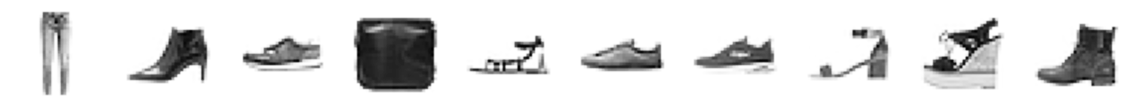

In [8]:
#Plot the images
for batch_idx, x in train_dataloader:
    show_images(x)
    break

# Data augmentation and pipeline

In [9]:
# code for data augmentation pipeline 

# Model definitions

In [10]:
# code for model definitions goes here
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.input_layer = nn.Linear(input_dim, hidden_dim) # can also give a convolutional input
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.sigma_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, batch_input):
        
        
        h = nn.ReLU()(self.input_layer(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.hidden_layer1(z))
        h_o = nn.ReLU()(self.hidden_layer2(h_o))
        
        reconstruction = nn.Sigmoid()(self.out(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma

In [11]:
#use a convolutional layer in the network


# code for model definitions goes here
class ConvEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, imgChannels =1, featureDim = 32*28*28):
        super(ConvEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 3, stride =1)
        self.encConv2 = nn.Conv2d(16, 32, 3, stride =1)
        self.encFC1 = nn.Linear(featureDim, latent_dim)
        self.encFC2 = nn.Linear(featureDim, latent_dim)

        
        #self.input_layer = nn.Linear(out_channels*32*32, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(featureDim, latent_dim)
        self.sigma_layer = nn.Linear(featureDim, latent_dim)
        
    def forward(self, batch_input):
        
        h = nn.ReLU()(self.encConv1(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.encConv2(h)) 
        #h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        h = h.view(-1, 32*28*28)
        
        
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class ConvDecoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim, imgChannels =1, featureDim = 32*28*28):
        super(ConvDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 3)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 3)

        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.decFC1(z))
        
        h_o = h_o.view(-1, 32,28,28)
        
        h_o = nn.ReLU()(self.decConv1(h_o))

        reconstruction = nn.Sigmoid()(self.decConv2(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class ConvVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvVAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma
    

# Training and validation loop

In [12]:
def save_model_checkpoint(path, model, optimizer, overall_loss, overall_reconstruction_loss, overall_kl_loss):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "overall_loss_dict": overall_loss,
                 "overall_reconstruction_dict": overall_reconstruction_loss,
                 "overall_kl_loss_dict": overall_kl_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [13]:
# write your training and validation loop here

# training and validation after every epoch
def train(model, train_loader, num_epochs, save_name):
    best_loss = float("Inf") 
    train_overall_loss, train_recons_loss, train_kl_loss = [], [], []
    cur_step = 0
    train_pred = []
    val_pred = []
    input_dim = 32*32
    batch_size = 10
    cnt = 0

    for epoch in range(num_epochs):
        overall_loss = 0.0 
        overall_recons_loss = 0.0
        overall_kl_loss = 0.0 
        model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, train_data in train_loader:   
            # Forward
            input_tensor = train_data.to(device)
            input_tensor = input_tensor.view(batch_size, 32*32)
            optimizer.zero_grad()
            outputs, mu, log_sigma = model.forward(input_tensor)
            loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma)
            overall_loss += loss.item()
            overall_recons_loss  += reconstruction_loss.item()
            overall_kl_loss += kl_loss
            cnt+=1
            
                
            # Backward and optimize
            loss.backward()
            optimizer.step()   
            
        n_datapoints =  cnt * batch_size #cnt gives the no of batches \times the batch_size = total_datapoitns
        avg_overall_loss = overall_loss / n_datapoints
        train_overall_loss.append(avg_overall_loss)
        
        avg_recons_loss = overall_recons_loss/ n_datapoints
        train_recons_loss.append(avg_recons_loss)
        
        avg_kl_loss = overall_kl_loss / n_datapoints
        train_kl_loss.append(avg_kl_loss)
        
        print("Train Pass Completed")
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_overall_loss, "\tReconstruction Loss:", avg_recons_loss, "\tKL Loss:", avg_kl_loss)

        if avg_recons_loss < best_loss:
            best_loss = avg_recons_loss
            save_model_checkpoint(save_name, model, optimizer, avg_overall_loss, best_loss,avg_kl_loss )
    
    print("Finished Training") 
    return train_overall_loss, train_recons_loss, train_kl_loss


In [14]:
# write your training and validation loop here

# training and validation after every epoch
def train_conv(model, train_loader, num_epochs, save_name):
    best_loss = float("Inf") 
    train_overall_loss, train_recons_loss, train_kl_loss = [], [], []
    cur_step = 0
    train_pred = []
    val_pred = []
    input_dim = 32*32
    batch_size = 10
    cnt = 0

    for epoch in range(num_epochs):
        overall_loss = 0.0 
        overall_recons_loss = 0.0
        overall_kl_loss = 0.0 
        model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, train_data in train_loader:   
            # Forward
            input_tensor = train_data.to(device)
            #input_tensor = input_tensor.view(batch_size,32*32)
            optimizer.zero_grad()
            outputs, mu, log_sigma = model.forward(input_tensor)
            loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma)
            overall_loss += loss.item()
            overall_recons_loss  += reconstruction_loss.item()
            overall_kl_loss += kl_loss
            cnt+=1
            
                
            # Backward and optimize
            loss.backward()
            optimizer.step()   
            
        n_datapoints = cnt * batch_size #cnt gives the no of batches \times the batch_size = total_datapoitns
        avg_overall_loss = overall_loss / n_datapoints
        train_overall_loss.append(avg_overall_loss)
        
        avg_recons_loss = overall_recons_loss/ n_datapoints
        train_recons_loss.append(avg_recons_loss)
        
        avg_kl_loss = overall_kl_loss / n_datapoints
        train_kl_loss.append(avg_kl_loss)
        
        print("Train Pass Completed")
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_overall_loss, "\tReconstruction Loss:", avg_recons_loss, "\tKL Loss:", avg_kl_loss)

        if avg_recons_loss < best_loss:
            best_loss = avg_recons_loss
            save_model_checkpoint(save_name, model, optimizer, avg_overall_loss, best_loss,avg_kl_loss )
    
    print("Finished Training") 
    return train_overall_loss, train_recons_loss, train_kl_loss


In [74]:
#Loss Criterion

def loss_criterion(x, x_reconstr, mu, log_sigma,reduce=True):
    if reduce:
        reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
        total_loss = reconstr_loss + kl_loss
    else:
        reconstr_loss =torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=(1,2,3))
        #print(reconstr_loss.shape)
        kl_loss =  0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        #print(kl_loss.shape)
        total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [ ]:
# perform training
import torch.optim as optim

device = "cuda:0"

encoder = Encoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 5).cuda()
decoder = Decoder(hidden_dim = 500, latent_dim = 5, output_dim = 32*32).cuda()

vae = VAE(encoder = encoder, decoder = decoder).cuda()

optimizer = optim.Adam(vae.parameters(), lr = 6e-4)
save_name = f'Vanilla_VAE.pt'
epochs = 100
obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss = train(vae, train_dataloader,
                                                                                        epochs , save_name )


In [45]:
# perform training
import torch.optim as optim

device = "cuda:0"

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 5).cuda()
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 5, output_dim = 32*32).cuda()

conv_vae = ConvVAE(encoder = encoder, decoder = decoder).cuda()

optimizer = optim.Adam(conv_vae.parameters(), lr = 3e-4)
save_name = f'Conv_VAE_100.pt'
epochs = 100
obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss = train_conv(conv_vae, train_dataloader,
                                                                                        epochs , save_name )


Starting epoch 1
<class 'float'>
Train Pass Completed
	Epoch 1 	Average Loss:  40.4211660731389 	Reconstruction Loss: 33.448752767709585 	KL Loss: tensor(6.9724, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100.pt
Starting epoch 2
<class 'float'>
Train Pass Completed
	Epoch 2 	Average Loss:  13.382058317331168 	Reconstruction Loss: 9.81873160142165 	KL Loss: tensor(3.5633, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100.pt
Starting epoch 3
<class 'float'>
Train Pass Completed
	Epoch 3 	Average Loss:  8.57606278091822 	Reconstruction Loss: 6.187260817503318 	KL Loss: tensor(2.3888, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100.pt
Starting epoch 4
<class 'float'>
Train Pass Completed
	Epoch 4 	Average Loss:  6.3068936233520505 	Reconstruction Loss: 4.504150563533489 	KL Loss: tensor(1.8027, device='cuda:0', grad_fn=<DivBackward0>)
Model Saved to ==> Conv_VAE_100.pt
Starting epoch 5
<class 'float'>
Train Pass Comp

# Inspection, Validation, and Analysis

In [ ]:
# Inspect, validate, and analyse your trained model

In [16]:
def create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,model_name,num_epochs,log_scale=True):
    # converted_overall_loss = [tensor.detach().item() for tensor in obtained_train_overall_loss]
    # converted_reconstruction_loss = [tensor.detach().item() for tensor in obtained_train_recons_loss]
    converted_kl_loss = [tensor.detach().item() for tensor in obtained_train_kl_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),obtained_train_overall_loss, label = "Overall Loss", color = "blue")
    plt.plot(range(0,num_epochs),obtained_train_recons_loss, label = "Reconstruction Loss", color = "red")
    plt.plot(range(0,num_epochs),converted_kl_loss, label = "KL Loss", color = "orange")


    plt.title('Loss Vs Epochs {Training}', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('Loss (Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()

In [17]:
#Plot for ConvVAE
create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,"ConvVAE",epochs,log_scale=True)

NameError: name 'obtained_train_overall_loss' is not defined

In [132]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
def anomaly_detection_evaluation(model, test_loader,device='cpu'):
    losses = []
    targets = []
    with torch.no_grad():
      model.eval()
      for val_data, val_targets in test_loader:
        
        # Forward
        input_tensor = val_data.to(device)
        outputs, mu, log_sigma = model.forward(input_tensor)
        #print(outputs)
        loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma,reduce=False)
        losses.append(loss)
        targets.append(val_targets[:,5]) # Targets are 1 for anomalies 0 for anything else
    scores = torch.stack(losses,axis=0).view(-1)
    targets = torch.stack(targets,axis=0).view(-1)
    scores = (scores - scores.min())/(scores.max()-scores.min())
    scores = scores.cpu().detach().numpy() # Convert to numpy
    fpr, tpr, roc_thresholds = roc_curve(targets, scores)
    precision, recall, pr_thresholds = precision_recall_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    return fpr,tpr,precision,recall,roc_auc,pr_auc

In [130]:

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 5)
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 5, output_dim = 32*32)

model = ConvVAE(encoder = encoder, decoder = decoder)
checkpoint = torch.load('Conv_VAE_100.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [127]:

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10)
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32)

model = ConvVAE(encoder = encoder, decoder = decoder)
checkpoint = torch.load('Conv_VAE_100_z_dim_10 .pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

roc_auc=0.9257596153846154


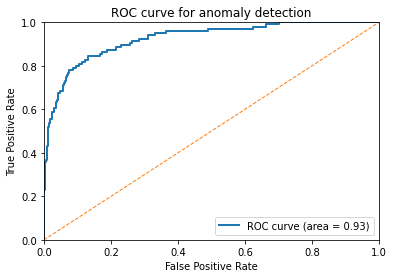

pr_auc=0.6073208810285122


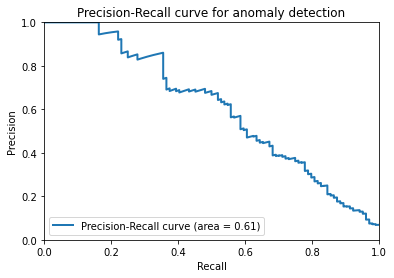

In [133]:
fpr,tpr,precision,recall,roc_auc,pr_auc = anomaly_detection_evaluation(model,test_dataloader)

print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()

roc_auc=0.9276153846153846


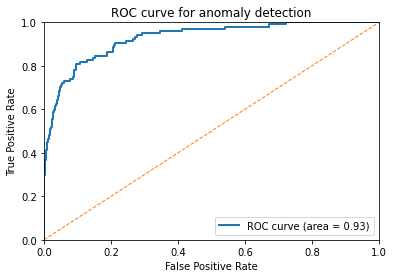

pr_auc=0.611544522833935


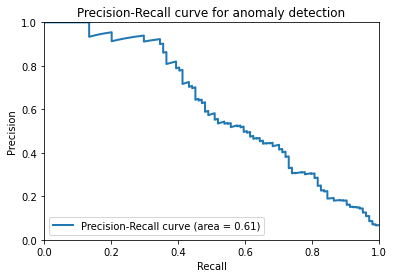

In [128]:
fpr,tpr,precision,recall,roc_auc,pr_auc = anomaly_detection_evaluation(model,test_dataloader)

print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()